<a href="https://colab.research.google.com/github/lokeshbaranwal/Pose-Estimation-of-Satellite/blob/master/Xception_Speedv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting the Google Drive to access the dataset.**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Importing all necessary packages.


*   The **preprocess_input** function is meant to adequate your image to the format the model requires
*  **ImageDataGenerator:** Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).



In [2]:

dataset_root="/content/gdrive/My Drive/speed"
import pandas as pd
import os
import json
import numpy as np
import keras
import tensorflow
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.applications.xception import preprocess_input  
from keras.models import Model
from keras.layers import Dense,Flatten,BatchNormalization,Activation,AlphaDropout
from sklearn.model_selection import train_test_split

  

Using TensorFlow backend.




1.   **with:** there is no need to call file.close() when using with statement. The with statement itself ensures proper acquisition and release of resource, it also takes care of all the exceptions by itself
2.   **os.path** contains functions for manipulating filenames and directory names.
3.**os.path.join()** function will add an extra slash to the pathname before joining it to the filename.



In [3]:
with open(os.path.join(dataset_root,'train.json'),'r') as train:
  train_json=json.load(train)
train_json[0]['q_vbs2tango']
#len(train_json)
type(train_json)
# q=train_json[i]['q_vbs2tango']
# r=train_json[i]['r_Vo2To_vbs_true']
# a=q.extend(r)


list

In [0]:
imgname_list=[]
for i in range(len(train_json)):
  imgname_list.append(train_json[i]['filename'])

#imgname_list

Putting all the images and corresponding 7 continuous values (4 from quaternion vector, 3 from position vector) in a Pandas dataframe to be able to use with **flow_from_dataframe** function
for multilabel regression.

In [0]:
label_list=[]
q1,q2,q3,q4,r1,r2,r3=[],[],[],[],[],[],[]
for i in range(len(train_json)):
  q1.append(train_json[i]['q_vbs2tango'][0])
  q2.append(train_json[i]['q_vbs2tango'][1])
  q3.append(train_json[i]['q_vbs2tango'][2])
  q4.append(train_json[i]['q_vbs2tango'][3])
  r1.append(train_json[i]['r_Vo2To_vbs_true'][0])
  r2.append(train_json[i]['r_Vo2To_vbs_true'][1])
  r3.append(train_json[i]['r_Vo2To_vbs_true'][2])
  #q.extend(r)
  #label_list.append(q)



In [6]:
col_dict={'image_names':imgname_list,'q1':q1,'q2':q2,'q3':q3,'q4':q4,'r1':r1,'r2':r2,'r3':r3}
df=pd.DataFrame(col_dict)
#df['labels']=label_list
df_train,df_test=train_test_split(df,test_size=0.2)
len(df_test)
df_train.head()

,image_names,q1,q2,q3,q4,r1,r2,r3
3740,img004690.jpg,0.243689,0.454623,0.846504,-0.131770,-0.043811,0.039634,7.129200
6032,img007541.jpg,0.392521,-0.134788,-0.138663,0.899184,0.024133,0.067672,6.387962
3346,img004198.jpg,0.910158,0.133061,-0.331903,0.209157,0.234262,0.394998,7.195157
11126,img013922.jpg,-0.349432,-0.452976,-0.456918,-0.681128,0.176779,0.336853,6.222410
9876,img012361.jpg,-0.398633,0.001036,0.714317,-0.575188,0.107574,-0.809857,18.510589


Previously, one should have to write a custom generator if they have to perform regression or predict multiple columns and utilize the image augmentation capabilities of the ImageDataGenerator, now we can have the target values as just another column/s (must be numerical datatype) in our dataframe, simply provide the column names to the **flow_from_dataframe** and we can now use all the augmentations provided by the ImageDataGenerator

In [7]:
path="/content/gdrive/My Drive/speed/images/train"
cols=['q1','q2','q3','q4','r1','r2','r3']
datagen=ImageDataGenerator(preprocessing_function=preprocess_input,zoom_range=0.2,brightness_range=[0.8,1.2]) #Values less than 1.0 darken the image, e.g. [0.5, 1.0], whereas values larger than 1.0 brighten the image, e.g. [1.0, 1.5], where 1.0 has no effect on brightness.
datagen2=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=datagen.flow_from_dataframe(df_train,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(299,299),batch_size=32,color_mode='rgb')
validation_generator=datagen2.flow_from_dataframe(df_test,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(299,299),batch_size=32,color_mode='rgb')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="image_names". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 9598 validated image filenames.
Found 2400 validated image filenames.


In [8]:
len(train_generator)

300

**Building our model using Transfer Learning.**

In [9]:

#tensorflow.keras.backend.set_learning_phase(0)
model_pretrained=Xception(weights='imagenet',include_top=False,input_shape=(299,299,3))
#tensorflow.keras.backend.set_learning_phase(1)

#using keras functional api to build our model

x=model_pretrained.output

#x=Flatten()(x)

#x=Dense(32,activation='selu',kernel_initializer='lecun_normal')(x)
        
#x=BatchNormalization()(x)

x=Dense(512,activation='elu',kernel_initializer='he_normal')(x) #
   
#x=AlphaDropout(0.1)(x)
        
# x=Dense(64,activation='selu',kernel_initializer='lecun_normal')(x) #
   
# x=AlphaDropout(0.1)(x)

#x=BatchNormalization()(x)
        
#x=Dense(128,activation='selu',kernel_initializer='lecun_normal')(x)
        
x=Flatten()(x)
        
x=Dense(7,activation='linear')(x)

model=Model(inputs=model_pretrained.input,outputs=x)


# step_size_train=train_generator.n//train_generator.batch_size #It should typically be equal to the number of samples of your dataset divided by the batch size.
# step_size_valid=validation_generator.n//validation_generator.batch_size
# history=model.fit_generator(train_generator,steps_per_epoch=step_size_train,epochs=2,validation_data=validation_generator,validation_steps=step_size_valid)


W0728 05:01:15.915287 140197540362112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 05:01:15.969877 140197540362112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 05:01:15.978011 140197540362112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 05:01:16.020266 140197540362112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0728 05:01:16.021544 1401975403

83689472/83683744 [==============================] - 3s 0us/step


**IMP** Which layers to train or not should be done before model compilation.

In [0]:
# train_generator[0][0][0][0][0]
# train_generator

In [11]:
for i,j in enumerate(model.layers):
  print(i,':',j)
for layer in model.layers[:17]:
  layer.trainable=False
for layer in model.layers[17:]:
  layer.trainable=True

0 : <keras.engine.input_layer.InputLayer object at 0x7f81f4cb6898>
1 : <keras.layers.convolutional.Conv2D object at 0x7f81f4cb6be0>
2 : <keras.layers.normalization.BatchNormalization object at 0x7f81f4cbf240>
3 : <keras.layers.core.Activation object at 0x7f81f4cbfa20>
4 : <keras.layers.convolutional.Conv2D object at 0x7f81f4cbf908>
5 : <keras.layers.normalization.BatchNormalization object at 0x7f81f42d9da0>
6 : <keras.layers.core.Activation object at 0x7f81e0a24be0>
7 : <keras.layers.convolutional.SeparableConv2D object at 0x7f81e094bac8>
8 : <keras.layers.normalization.BatchNormalization object at 0x7f81e08f5668>
9 : <keras.layers.core.Activation object at 0x7f81e0802cc0>
10 : <keras.layers.convolutional.SeparableConv2D object at 0x7f81e082c4a8>
11 : <keras.layers.normalization.BatchNormalization object at 0x7f81e07b6710>
12 : <keras.layers.convolutional.Conv2D object at 0x7f81e09f7cc0>
13 : <keras.layers.pooling.MaxPooling2D object at 0x7f81e0704f98>
14 : <keras.layers.normalization.

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [13]:

sgd=keras.optimizers.sgd(lr=1e-3,decay=0, momentum=0.9, nesterov=True)
adam=keras.optimizers.adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=1e-20,mode='min',verbose=1)
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='min',min_delta=0.01,restore_best_weights=True)
model.compile(optimizer=adam,loss='mean_squared_error') #,metrics=['mse']
step_size_train=train_generator.n//train_generator.batch_size #It should typically be equal to the number of samples of your dataset divided by the batch size.
step_size_valid=validation_generator.n//validation_generator.batch_size
history=model.fit_generator(train_generator,steps_per_epoch=step_size_train,epochs=20,validation_data=validation_generator,validation_steps=step_size_valid,callbacks=[reduce_lr]) #,early_stopping


W0728 05:01:30.300461 140197540362112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Epoch 1/20
299/299 [==============================] - 3847s 13s/step - loss: 2.5303 - val_loss: 1.1454
Epoch 2/20
299/299 [==============================] - 647s 2s/step - loss: 0.8360 - val_loss: 1.1833
Epoch 3/20
299/299 [==============================] - 616s 2s/step - loss: 0.7304 - val_loss: 1.6991
Epoch 4/20
299/299 [==============================] - 629s 2s/step - loss: 0.6088 - val_loss: 0.6748
Epoch 5/20
299/299 [==============================] - 643s 2s/step - loss: 0.5574 - val_loss: 0.9427
Epoch 6/20
299/299 [==============================] - 623s 2s/step - loss: 0.5373 - val_loss: 1.2660
Epoch 7/20
299/299 [==============================] - 635s 2s/step - loss: 0.4401 - val_loss: 0.6040
Epoch 8/20
299/299 [==============================] - 645s 2s/step - loss: 0.4023 - val_loss: 0.8910
Epoch 9/20
299/299 [==============================] - 635s 2s/step - loss: 0.6650 - val_loss: 1.3341
Epoch 10/20
299/299 [==============================] - 648s 2s/step - loss: 0.4141 - val_

In [14]:

for e,v in enumerate(history.history['val_loss']):
  print("Epoch ",e,":",v)

Epoch  0 : 1.1453551081816356
Epoch  1 : 1.1832973988850912
Epoch  2 : 1.6990661168098449
Epoch  3 : 0.6748026303450266
Epoch  4 : 0.9427259564399719
Epoch  5 : 1.2659528489907583
Epoch  6 : 0.60396764198939
Epoch  7 : 0.8910454825560252
Epoch  8 : 1.3341073950131734
Epoch  9 : 3.0767818053563434
Epoch  10 : 0.9592177704970042
Epoch  11 : 0.6280306828022003
Epoch  12 : 0.8843392241001129
Epoch  13 : 0.8276871099074682
Epoch  14 : 0.7190560607115427
Epoch  15 : 0.7958229058980941
Epoch  16 : 0.792757914463679
Epoch  17 : 0.7942549695571264
Epoch  18 : 0.7902185642719268
Epoch  19 : 0.8431891546646754


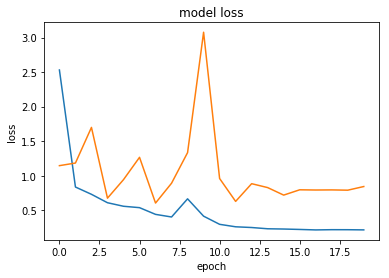

In [15]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [16]:
#Evaluating the model
test_result=[]
q_est,r_est=[],[]
with open(os.path.join(dataset_root,'real.json'),'r') as f_eval:
  test_list=json.load(f_eval)

for img in test_list:
  img_path=os.path.join(dataset_root,'images','real',img['filename'])
  img_arr=image.load_img(img_path,target_size=(299,299))
  x=image.img_to_array(img_arr)
  x=preprocess_input(x)
  x=np.expand_dims(x,axis=0)
  output=model.predict(x)
  output=output.tolist()
  test_result.append({'filename':img['filename'],'q':output[:4],'r':output[4:]})
  q_est.append(output[0][:4])
  r_est.append(output[0][4:])
  print(output)


[[-0.039894480258226395, 0.012698928825557232, 0.048464350402355194, 0.03524342179298401, 0.06206897646188736, 0.12458525598049164, 3.800396203994751]]
[[-0.012236950919032097, 0.006193122826516628, 0.021773692220449448, 0.025049690157175064, -0.03980105370283127, 0.06626344472169876, 3.741274356842041]]
[[0.0034150113351643085, 0.0010523919481784105, -0.031849369406700134, -0.010387741029262543, -0.20859725773334503, -0.012359973043203354, 5.512204170227051]]
[[-0.016036713495850563, -0.0028713673818856478, -0.016843032091856003, -0.01704413816332817, -0.06597919017076492, -0.0061798421666026115, 4.708830833435059]]
[[-0.056888993829488754, -0.03617309033870697, -0.07861077040433884, -0.03139723464846611, -0.17978467047214508, -0.1343381702899933, 5.122743606567383]]


In [0]:
# img_path=os.path.join(dataset_root,'images','test','img000014.jpg')
# img_arr=image.load_img(img_path,target_size=(299,299))
# x=image.img_to_array(img_arr)
# x=preprocess_input(x)
# x=np.expand_dims(x,axis=0)
# output=model.predict(x)
# output=output.tolist()
# output

**Extracting r_gt and q_gt from real.json**

In [23]:
real_json=[]
q_gt,r_gt=[],[]
image_name=[]
with open(os.path.join(dataset_root,'real.json'),'r') as f:
  real_json=json.load(f)
for i in range(len(real_json)):
  image_name.append(real_json[i]['filename'])
  q_gt.append(real_json[i]['q_vbs2tango'])
  r_gt.append(real_json[i]['r_Vo2To_vbs_true'])
image_name

['img000187real.jpg',
 'img000195real.jpg',
 'img000120real.jpg',
 'img000450real.jpg',
 'img000240real.jpg']

**Calculating Orientation Score.**

Orientation score is the angle of the rotation, that aligns the estimated and ground truth orientations:

score(i)orientation=2⋅arccos(∣∣⟨q(i)est,q(i)gt⟩∣∣)

In [24]:
import math
score_orientation=0
bra_ket=[]
for i in range(len(real_json)):
  bra_ket.append(q_est[i][0]*q_gt[i][0]+q_est[i][1]*q_gt[i][1]+q_est[i][2]*q_gt[i][2]+q_est[i][3]*q_gt[i][3])
  
  
for i in range(len(real_json)):
  if bra_ket[i]<1:
    score_orientation+=2*math.acos(bra_ket[i])
score_orientation
#bra_ket



15.846364351793087

**Calculating Position Score**

The position score for image i is simply the 2-norm of the position error (difference of estimated and ground truth position vectors), normalized with the ground truth distance of the satellite:

score(i)position=∣∣r(i)gt−r(i)est∣∣2∣∣r(i)gt∣∣2

In [25]:
from numpy import linalg
score_position=0
for i in range(len(real_json)):
   score_position+=(abs(linalg.norm([r_gt[i]],2)-linalg.norm([r_est[i]],2))/linalg.norm([r_gt[i]],2))

#linalg.norm([r_gt[0]])
score_position

0.9014768695375214

**Finally, the total score is the average of pose scores over all images of the test set:**

In [26]:
score=(score_orientation+score_position)/len(real_json)
score

3.349568244266121

In [0]:
from matplotlib import pyplot as plt
from random import randint
from PIL import Image

In [40]:
train_json1=[]
image_name1=[]
with open(os.path.join(dataset_root,'train.json'),'r') as f:
  train_json1=json.load(f)
for i in range(len(train_json1)):
  image_name1.append(train_json1[i]['filename'])
image_name1[1]

'img000002.jpg'

In [0]:
def get_image(i):

    """ Loading image as PIL image. """
    img_name = image_name1[i]
    img_name = os.path.join(dataset_root, 'images/train', img_name)
    image = Image.open(img_name).convert('RGB')
    return image


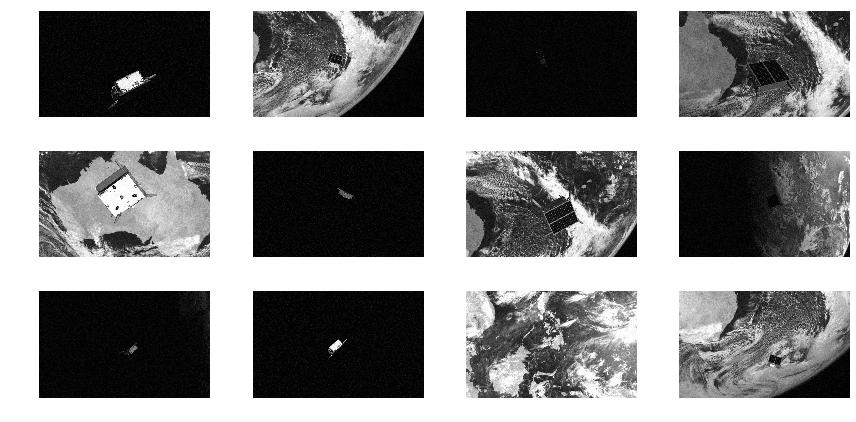

In [44]:
rows = 3
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i in range(rows):
    for j in range(cols):
        img = get_image(randint(0, 12000))
        axes[i][j].imshow(img)
        axes[i][j].axis('off')
fig.tight_layout()